In [24]:
import pandas as pd
import torch, os, sys
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchvision.transforms import RandAugment
from torch.utils.data import Dataset, DataLoader, RandomSampler
import torch
from itertools import cycle
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt

print("CUDA:", torch.cuda.is_available(), "| GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

CUDA: True | GPU: Tesla T4


In [2]:
# ===== 1) Buscando o CIFAR-10 =====
def find_cifar10_input_root(base="/kaggle/working"):
    if not os.path.exists(base):
        return None
    for root, dirs, files in os.walk(base):
        # Estrutura padrão do CIFAR-10 (torchvision extrai para 'cifar-10-batches-py')
        if "cifar-10-batches-py" in dirs:
            return root  # <- datasets.CIFAR10 espera o 'root' acima desse diretório
    return None

INPUT_ROOT = find_cifar10_input_root()
if INPUT_ROOT is not None:
    DATA_ROOT = INPUT_ROOT
    DOWNLOAD = False
    print(f"Usando CIFAR-10 de /kaggle/input (root: {DATA_ROOT})")
else:
    DATA_ROOT = "/kaggle/working/data"  # gravável
    os.makedirs(DATA_ROOT, exist_ok=True)
    DOWNLOAD = True
    print(f"CIFAR-10 não encontrado em /kaggle/input. "
          f"Baixando para {DATA_ROOT} (requer Internet=ON).")

# ===== 2) Transforms =====
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2023, 0.1994, 0.2010)

train_tfm = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# ===== 3) Carregamento =====
train_set = datasets.CIFAR10(DATA_ROOT, train=True,  download=DOWNLOAD, transform=train_tfm)
test_set  = datasets.CIFAR10(DATA_ROOT, train=False, download=DOWNLOAD, transform=test_tfm)

# ===== 4) DataLoaders =====
train_loader = DataLoader(train_set, batch_size=128, shuffle=True,  num_workers=2, pin_memory=True, drop_last=False)
test_loader  = DataLoader(test_set,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

print("Tamanhos:", len(train_set), len(test_set))

CIFAR-10 não encontrado em /kaggle/input. Baixando para /kaggle/working/data (requer Internet=ON).


100%|██████████| 170M/170M [00:02<00:00, 64.4MB/s] 


Tamanhos: 50000 10000


In [3]:
class FixMatchLoss(nn.Module):
    def __init__(self, tau=0.95, lambda_u=1.0):
        super().__init__()
        self.tau = tau; self.lambda_u = lambda_u
        self.ce = nn.CrossEntropyLoss()
    @torch.no_grad()
    def pseudo(self, logits_weak):
        p = torch.softmax(logits_weak, dim=1)
        conf, yhat = p.max(dim=1)
        mask = (conf >= self.tau).float()
        return yhat, mask
    def forward(self, logits_sup, y_sup, logits_w, logits_s):
        Ls = self.ce(logits_sup, y_sup)
        yhat, mask = self.pseudo(logits_w)
        Lu_all = F.cross_entropy(logits_s, yhat, reduction='none')
        Lu = (Lu_all * mask).sum() / (mask.sum().clamp_min(1.0))
        return Ls + self.lambda_u*Lu, (Ls.item(), Lu.item(), mask.mean().item())

In [14]:
num_classes = 10
SEED = 22

weak_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


strong_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    RandAugment(num_ops=2, magnitude=10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_full = datasets.CIFAR10(DATA_ROOT, train=True,  download=False, transform=None)
test_set   = datasets.CIFAR10(DATA_ROOT, train=False, download=False, transform=test_transform)

targets = np.array(train_full.targets)

def stratified_per_class_indices(targets, labels_per_class, seed=SEED):
    rng = np.random.default_rng(seed)
    idxs = []
    for c in range(num_classes):
        cand = np.where(targets == c)[0]
        choose = rng.choice(cand, size=labels_per_class, replace=False)
        idxs.extend(choose.tolist())
    return sorted(idxs)

class LabeledCIFAR10(Dataset):
    def __init__(self, base, indices, transform):
        self.base = base
        self.indices = indices
        self.transform = transform
    def __len__(self): return len(self.indices)
    def __getitem__(self, i):
        idx = self.indices[i]
        x, y = self.base.data[idx], self.base.targets[idx]
        x = transforms.ToPILImage()(x)
        return self.transform(x), y

class UnlabeledFixMatchCIFAR10(Dataset):
    def __init__(self, base, indices, weak_t, strong_t):
        self.base = base
        self.indices = indices
        self.weak_t = weak_t
        self.strong_t = strong_t
    def __len__(self): return len(self.indices)
    def __getitem__(self, i):
        idx = self.indices[i]
        x = transforms.ToPILImage()(self.base.data[idx])
        return self.weak_t(x), self.strong_t(x)

labels_per_class = 70  

labeled_idx   = stratified_per_class_indices(targets, labels_per_class, seed=SEED)
unlabeled_idx = sorted(list(set(range(len(train_full))) - set(labeled_idx)))

labeled_ds   = LabeledCIFAR10(train_full, labeled_idx,   transform=weak_transform)    # supervisionado
unlabeled_ds = UnlabeledFixMatchCIFAR10(train_full, unlabeled_idx, weak_t=weak_transform, strong_t=strong_transform)

# 4) Loaders (1:7 é a razão sup:unsup típica)

n_labeled = len(labeled_ds)
n_unlabeled = len(unlabeled_ds)

# Ajuste dinâmico para não ficar sem batch supervisionado
batch_sup_cfg = 64  # seu alvo
drop_last_sup = True
if n_labeled < batch_sup_cfg:
    print(f"n_labeled={n_labeled} < batch_sup_cfg={batch_sup_cfg} → ajustando batch_sup e drop_last.")
    batch_sup = n_labeled
    drop_last_sup = False
else:
    batch_sup = batch_sup_cfg

# reduzir unsup se estiver muito desbalanceado para sua GPU
batch_unsup_cfg = 448
batch_unsup = min(batch_unsup_cfg, n_unlabeled)  # garante ao menos 1 batch


sup_loader   = DataLoader(labeled_ds,   batch_size=batch_sup,  drop_last=drop_last_sup, num_workers=2, pin_memory=True, sampler=RandomSampler(labeled_ds,replacement=True,num_samples=batch_sup * 128))
unsup_loader = DataLoader(unlabeled_ds, batch_size=batch_unsup, shuffle=True,  drop_last=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,     batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

# Sanity check
xb_sup, yb_sup = next(iter(sup_loader))
xu_w, xu_s     = next(iter(unsup_loader))
print("Sup batch:", xb_sup.shape, yb_sup.shape)
print("Unsup weak/strong:", xu_w.shape, xu_s.shape)

Sup batch: torch.Size([64, 3, 32, 32]) torch.Size([64])
Unsup weak/strong: torch.Size([448, 3, 32, 32]) torch.Size([448, 3, 32, 32])


In [10]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def build_model(num_classes=10):
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(DEVICE)

@torch.no_grad()
def evaluate(model, test_loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    ce = nn.CrossEntropyLoss(reduction='sum')
    for xb, yb in test_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss_sum += ce(logits, yb).item()
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
    return {
        "acc": 100.0 * correct / total,
        "loss": loss_sum / total
    }

def train_one_epoch_fixmatch(model, sup_loader, unsup_loader, optimizer, fm_loss, use_amp=True, ema_state=None, ema_decay=0.999):
    """
    Treina 1 época usando:
      - batches supervisionados de sup_loader
      - batches não rotulados 'em paralelo' vindos de unsup_loader (ciclando se necessário)
    Retorna médias de: loss total, Ls, Lu, mask_mean
    Atualiza também o modelo EMA (Exponential Moving Average), se fornecido.
    """
    model.train()
    scaler = torch.amp.GradScaler('cuda', enabled=(use_amp and DEVICE.type == 'cuda'))

    L_all, Ls_all, Lu_all, m_all = [], [], [], []
    unsup_iter = cycle(unsup_loader)   # cicla para nunca faltar não-rotulado

    for xb, yb in tqdm(sup_loader, desc="Treinando batches", leave=False, dynamic_ncols=True):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        xu_w, xu_s = next(unsup_iter)
        xu_w, xu_s = xu_w.to(DEVICE), xu_s.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)

        if scaler.is_enabled():
            with torch.amp.autocast('cuda'):
                logits_sup    = model(xb)
                logits_weak   = model(xu_w)
                logits_strong = model(xu_s)
                loss, parts   = fm_loss(logits_sup, yb, logits_weak, logits_strong)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits_sup    = model(xb)
            logits_weak   = model(xu_w)
            logits_strong = model(xu_s)
            loss, parts   = fm_loss(logits_sup, yb, logits_weak, logits_strong)
            loss.backward()
            optimizer.step()

        if ema_state is not None:
            with torch.no_grad():
                for k, v in model.state_dict().items():
                    if k in ema_state:
                        if torch.is_floating_point(v):  # só atualiza tensores float
                            ema_state[k].mul_(ema_decay).add_(v.detach(), alpha=1 - ema_decay)
                        else:
                            ema_state[k] = v.clone()

        L_all.append(loss.item())
        Ls_all.append(parts[0] if isinstance(parts, (list, tuple)) else parts['Ls'])
        Lu_all.append(parts[1] if isinstance(parts, (list, tuple)) else parts['Lu'])
        m_all .append(parts[2] if isinstance(parts, (list, tuple)) else parts['mask_mean'])

    return {
        "loss": float(np.mean(L_all)),
        "Ls":   float(np.mean(Ls_all)),
        "Lu":   float(np.mean(Lu_all)),
        "mask": float(np.mean(m_all)),
    }

In [6]:
# Parâmetros básicos
EPOCHS   = 50
LR       = 0.03
MOM      = 0.9
WD       = 5e-4
TAU      = 0.95
LAMBDA_U = 1.0
EMA_DECAY = 0.999  # decaimento da média móvel exponencial

# Instancia modelo, otimizador e a sua classe FixMatchLoss
model   = build_model(num_classes=10)
optim   = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOM, nesterov=True, weight_decay=WD)
fm_loss = FixMatchLoss(tau=TAU, lambda_u=LAMBDA_U)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=EPOCHS, eta_min=0.0)

# === Inicializa o estado EMA ===
ema_state = {k: v.clone().detach() for k, v in model.state_dict().items()}

history = {"train_loss":[], "train_Ls":[], "train_Lu":[], "train_mask":[], "test_acc":[], "test_loss":[]}
best = {"acc": 0.0, "state": None, "epoch": -1}

@torch.no_grad()
def evaluate_ema(model, ema_state, test_loader):
    """Avalia o modelo suavizado pela EMA."""
    backup = {k: v.clone() for k, v in model.state_dict().items()}
    model.load_state_dict(ema_state, strict=False)
    result = evaluate(model, test_loader)
    model.load_state_dict(backup)
    return result

for ep in range(1, EPOCHS+1):
    tr = train_one_epoch_fixmatch(
        model, sup_loader, unsup_loader,
        optim, fm_loss, use_amp=True,
        ema_state=ema_state, ema_decay=EMA_DECAY
    )

    # Avalia o modelo suavizado (EMA)
    ev = evaluate_ema(model, ema_state, test_loader)

    scheduler.step()

    # Histórico
    history["train_loss"].append(tr["loss"])
    history["train_Ls"].append(tr["Ls"])
    history["train_Lu"].append(tr["Lu"])
    history["train_mask"].append(tr["mask"])
    history["test_acc"].append(ev["acc"])
    history["test_loss"].append(ev["loss"])

    # Melhor modelo
    if ev["acc"] > best["acc"]:
        best = {"acc": ev["acc"], "state": {k:v.cpu() for k,v in ema_state.items()}, "epoch": ep}
        torch.save(best["state"], "best_model.pth")

    print(f"Ep {ep:03d} | L={tr['loss']:.3f} (Ls={tr['Ls']:.3f}, Lu={tr['Lu']:.3f}, m={tr['mask']:.2f}) "
          f"| Test Acc ={ev['acc']:.2f}%")

# === Carrega o melhor modelo e reavalia ===
if best["state"] is not None:
    model.load_state_dict(best["state"], strict=False)
final_ev = evaluate(model, test_loader)
print(f"Melhor acc: {best['acc']:.2f}% @ epoch {best['epoch']} | Final acc: {final_ev['acc']:.2f}%")

Ep 001 | L=2.958 (Ls=2.560, Lu=0.398, m=0.04) | Test Acc =17.62%


Ep 002 | L=1.712 (Ls=1.247, Lu=0.465, m=0.08) | Test Acc =31.23%


Ep 003 | L=1.017 (Ls=0.435, Lu=0.581, m=0.22) | Test Acc =41.64%


Ep 004 | L=0.743 (Ls=0.176, Lu=0.566, m=0.31) | Test Acc =46.12%


Ep 005 | L=0.641 (Ls=0.107, Lu=0.534, m=0.36) | Test Acc =48.87%


Ep 006 | L=0.562 (Ls=0.071, Lu=0.491, m=0.40) | Test Acc =50.51%


Ep 007 | L=0.524 (Ls=0.057, Lu=0.467, m=0.41) | Test Acc =52.26%


Ep 008 | L=0.514 (Ls=0.053, Lu=0.462, m=0.42) | Test Acc =53.64%


Ep 009 | L=0.492 (Ls=0.047, Lu=0.445, m=0.43) | Test Acc =54.63%


Ep 010 | L=0.457 (Ls=0.041, Lu=0.416, m=0.45) | Test Acc =55.64%


Ep 011 | L=0.470 (Ls=0.040, Lu=0.430, m=0.45) | Test Acc =56.37%


Ep 012 | L=0.444 (Ls=0.034, Lu=0.410, m=0.47) | Test Acc =57.40%


Ep 013 | L=0.431 (Ls=0.031, Lu=0.400, m=0.47) | Test Acc =58.56%


Ep 014 | L=0.422 (Ls=0.031, Lu=0.391, m=0.49) | Test Acc =59.62%


Ep 015 | L=0.394 (Ls=0.025, Lu=0.368, m=0.49) | Test Acc =60.33%


Ep 016 | L=0.417 (Ls=0.029, Lu=0.388, m=0.50) | Test Acc =61.04%


Ep 017 | L=0.398 (Ls=0.023, Lu=0.375, m=0.51) | Test Acc =61.58%


Ep 018 | L=0.393 (Ls=0.025, Lu=0.369, m=0.52) | Test Acc =61.88%


Ep 019 | L=0.370 (Ls=0.021, Lu=0.349, m=0.51) | Test Acc =62.33%


Ep 020 | L=0.361 (Ls=0.019, Lu=0.342, m=0.53) | Test Acc =62.96%


Ep 021 | L=0.343 (Ls=0.020, Lu=0.322, m=0.53) | Test Acc =63.61%


Ep 022 | L=0.372 (Ls=0.018, Lu=0.354, m=0.55) | Test Acc =64.05%


Ep 023 | L=0.345 (Ls=0.015, Lu=0.330, m=0.57) | Test Acc =64.33%


Ep 024 | L=0.364 (Ls=0.015, Lu=0.348, m=0.56) | Test Acc =64.34%


Ep 025 | L=0.370 (Ls=0.016, Lu=0.355, m=0.58) | Test Acc =64.71%


Ep 026 | L=0.349 (Ls=0.012, Lu=0.337, m=0.59) | Test Acc =64.76%


Ep 027 | L=0.307 (Ls=0.011, Lu=0.296, m=0.58) | Test Acc =65.28%


Ep 028 | L=0.311 (Ls=0.010, Lu=0.301, m=0.59) | Test Acc =65.71%


Ep 029 | L=0.315 (Ls=0.010, Lu=0.304, m=0.59) | Test Acc =65.81%


Ep 030 | L=0.275 (Ls=0.009, Lu=0.266, m=0.59) | Test Acc =65.93%


Ep 031 | L=0.274 (Ls=0.007, Lu=0.267, m=0.60) | Test Acc =66.04%


Ep 032 | L=0.280 (Ls=0.008, Lu=0.273, m=0.61) | Test Acc =66.58%


Ep 033 | L=0.255 (Ls=0.007, Lu=0.248, m=0.61) | Test Acc =66.71%


Ep 034 | L=0.238 (Ls=0.006, Lu=0.232, m=0.62) | Test Acc =66.99%


Ep 035 | L=0.236 (Ls=0.005, Lu=0.231, m=0.62) | Test Acc =67.14%


Ep 036 | L=0.250 (Ls=0.004, Lu=0.245, m=0.63) | Test Acc =67.17%


Ep 037 | L=0.244 (Ls=0.004, Lu=0.241, m=0.63) | Test Acc =66.96%


Ep 038 | L=0.237 (Ls=0.003, Lu=0.233, m=0.65) | Test Acc =66.89%


Ep 039 | L=0.227 (Ls=0.003, Lu=0.224, m=0.65) | Test Acc =66.98%


Ep 040 | L=0.217 (Ls=0.003, Lu=0.214, m=0.65) | Test Acc =67.16%


Ep 041 | L=0.218 (Ls=0.002, Lu=0.217, m=0.65) | Test Acc =67.31%


Ep 042 | L=0.227 (Ls=0.003, Lu=0.224, m=0.66) | Test Acc =67.43%


Ep 043 | L=0.221 (Ls=0.002, Lu=0.219, m=0.66) | Test Acc =67.47%


Ep 044 | L=0.228 (Ls=0.002, Lu=0.226, m=0.67) | Test Acc =67.45%


Ep 045 | L=0.235 (Ls=0.002, Lu=0.233, m=0.66) | Test Acc =67.64%


Ep 046 | L=0.240 (Ls=0.002, Lu=0.238, m=0.66) | Test Acc =67.89%


Ep 047 | L=0.251 (Ls=0.002, Lu=0.250, m=0.66) | Test Acc =67.72%


Ep 048 | L=0.264 (Ls=0.002, Lu=0.263, m=0.66) | Test Acc =67.73%


Ep 049 | L=0.273 (Ls=0.002, Lu=0.271, m=0.65) | Test Acc =67.79%


Ep 050 | L=0.270 (Ls=0.001, Lu=0.269, m=0.64) | Test Acc =67.85%
Melhor acc: 67.89% @ epoch 46 | Final acc: 67.89%


In [18]:
def get_dataloaders(labels_per_class: int,
                    seed: int = SEED,
                    batch_sup_cfg: int = 64,
                    batch_unsup_cfg: int = 448,
                    num_classes: int = num_classes):
    """
    Constrói loaders para um dado labels_per_class reutilizando:
      - train_full, test_set
      - weak_transform, strong_transform, test_transform
      - targets, SEED
    Mantém sua lógica de sampler com reposição e 'num_samples = batch_sup * 256'.
    """
    labeled_idx   = stratified_per_class_indices(targets, labels_per_class, seed=SEED)
    unlabeled_idx = sorted(list(set(range(len(train_full))) - set(labeled_idx)))
    
    labeled_ds   = LabeledCIFAR10(train_full, labeled_idx,   transform=weak_transform)    # supervisionado
    unlabeled_ds = UnlabeledFixMatchCIFAR10(train_full, unlabeled_idx, weak_t=weak_transform, strong_t=strong_transform)
    
    # 4) Loaders (1:7 é a razão sup:unsup típica)
    
    n_labeled = len(labeled_ds)
    n_unlabeled = len(unlabeled_ds)
    
    # Ajuste dinâmico para não ficar sem batch supervisionado
    #batch_sup_cfg = 64  # seu alvo
    drop_last_sup = True
    if n_labeled < batch_sup_cfg:
        print(f"n_labeled={n_labeled} < batch_sup_cfg={batch_sup_cfg} → ajustando batch_sup e drop_last.")
        batch_sup = n_labeled
        drop_last_sup = False
    else:
        batch_sup = batch_sup_cfg
    
    # reduzir unsup se estiver muito desbalanceado para sua GPU
    #batch_unsup_cfg = 448
    batch_unsup = min(batch_unsup_cfg, n_unlabeled)  # garante ao menos 1 batch

 

    sup_loader   = DataLoader(labeled_ds,   batch_size=batch_sup,  drop_last=drop_last_sup, num_workers=2, pin_memory=True, sampler=RandomSampler(labeled_ds,replacement=True,num_samples=batch_sup * 256))
    unsup_loader = DataLoader(unlabeled_ds, batch_size=batch_unsup, shuffle=True,  drop_last=True, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_set,     batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    return sup_loader, unsup_loader, test_loader

In [20]:
# ----------------------------
# CONFIGURAÇÕES DO EXPERIMENTO
# ----------------------------
SCENARIOS = [400, 70, 25, 4, 1]   # rótulos por classe

# Ramyro -> TAUS = [0.95]
# Anderson  -> TAUS = [0.90]
# Léo -> TAUS = [0.80]
TAUS = [0.80]   

EPOCHS    = 30
LR        = 0.03
MOM       = 0.9
WD        = 5e-4
LAMBDA_U  = 1.0
EMA_DECAY = 0.999
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# FUNÇÃO DE AVALIAÇÃO EMA
# ----------------------------
@torch.no_grad()
def evaluate_ema(model, ema_state, test_loader):
    backup = {k: v.clone() for k, v in model.state_dict().items()}
    model.load_state_dict(ema_state, strict=False)
    result = evaluate(model, test_loader)
    model.load_state_dict(backup)
    return result


# ----------------------------
# LOOP PRINCIPAL DE TREINO
# ----------------------------

all_hist = []

for lpc in SCENARIOS:

    sup_loader, unsup_loader, test_loader = get_dataloaders(labels_per_class=lpc)

    for TAU in TAUS:

        model    = build_model(num_classes=10).to(DEVICE)
        optim    = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOM,
                                   nesterov=True, weight_decay=WD)
        fm_loss  = FixMatchLoss(tau=TAU, lambda_u=LAMBDA_U)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optim, T_max=EPOCHS, eta_min=0.0
        )

        ema_state = {k: v.clone().detach() for k, v in model.state_dict().items()}

        history = {
            "epoch":[], "train_loss":[], "train_Ls":[],
            "train_Lu":[], "train_mask":[],
            "test_acc":[], "test_loss":[]
        }

        best = {"acc": 0.0, "state": None, "epoch": -1}

        for ep in range(1, EPOCHS+1):

            tr = train_one_epoch_fixmatch(
                model, sup_loader, unsup_loader,
                optim, fm_loss, use_amp=True,
                ema_state=ema_state, ema_decay=EMA_DECAY
            )

            ev = evaluate_ema(model, ema_state, test_loader)
            scheduler.step()

            # salva métricas
            history["epoch"].append(ep)
            history["train_loss"].append(tr["loss"])
            history["train_Ls"].append(tr["Ls"])
            history["train_Lu"].append(tr["Lu"])
            history["train_mask"].append(tr["mask"])
            history["test_acc"].append(ev["acc"])
            history["test_loss"].append(ev["loss"])

            if ev["acc"] > best["acc"]:
                best = {
                    "acc": ev["acc"],
                    "state": {k: v.cpu() for k,v in ema_state.items()},
                    "epoch": ep
                }

            print(
                f"[lpc={lpc:>3}, τ={TAU:.2f}] Ep {ep:03d} | "
                f"L={tr['loss']:.3f} (Ls={tr['Ls']:.3f}, Lu={tr['Lu']:.3f}, m={tr['mask']:.2f}) "
                f"| Test Acc={ev['acc']:.2f}%"
            )

        # dataframe do cenário atual
        df = pd.DataFrame(history)
        df.insert(0, "labels_per_class", lpc)
        df.insert(1, "tau", TAU)
        all_hist.append(df)

# junta tudo deste notebook
curvas = pd.concat(all_hist, ignore_index=True)

# ----------------------------
# SALVAR ARQUIVO PARA COMPARTILHAR
# ----------------------------
nome_arquivo = f"curvas_tau_{TAUS[0]}.csv"
curvas.to_csv(nome_arquivo, index=False)

print(f"\nArquivo salvo: {nome_arquivo}")


[lpc=400, τ=0.80] Ep 001 | L=3.230 (Ls=2.687, Lu=0.544, m=0.11) | Test Acc=12.87%


[lpc=400, τ=0.80] Ep 002 | L=2.324 (Ls=1.909, Lu=0.415, m=0.13) | Test Acc=23.69%


[lpc=400, τ=0.80] Ep 003 | L=2.108 (Ls=1.581, Lu=0.527, m=0.19) | Test Acc=32.23%


[lpc=400, τ=0.80] Ep 004 | L=1.812 (Ls=1.317, Lu=0.495, m=0.26) | Test Acc=39.34%


[lpc=400, τ=0.80] Ep 005 | L=1.613 (Ls=1.120, Lu=0.493, m=0.33) | Test Acc=46.22%


[lpc=400, τ=0.80] Ep 006 | L=1.451 (Ls=0.952, Lu=0.499, m=0.39) | Test Acc=50.98%


[lpc=400, τ=0.80] Ep 007 | L=1.330 (Ls=0.831, Lu=0.499, m=0.44) | Test Acc=55.11%


[lpc=400, τ=0.80] Ep 008 | L=1.216 (Ls=0.715, Lu=0.501, m=0.48) | Test Acc=58.31%


[lpc=400, τ=0.80] Ep 009 | L=1.122 (Ls=0.615, Lu=0.507, m=0.51) | Test Acc=60.72%


[lpc=400, τ=0.80] Ep 010 | L=1.033 (Ls=0.529, Lu=0.504, m=0.54) | Test Acc=63.18%


[lpc=400, τ=0.80] Ep 011 | L=0.954 (Ls=0.457, Lu=0.497, m=0.57) | Test Acc=64.93%


[lpc=400, τ=0.80] Ep 012 | L=0.884 (Ls=0.384, Lu=0.500, m=0.60) | Test Acc=66.76%


[lpc=400, τ=0.80] Ep 013 | L=0.830 (Ls=0.322, Lu=0.509, m=0.62) | Test Acc=67.84%


[lpc=400, τ=0.80] Ep 014 | L=0.778 (Ls=0.277, Lu=0.501, m=0.65) | Test Acc=69.13%


[lpc=400, τ=0.80] Ep 015 | L=0.729 (Ls=0.224, Lu=0.505, m=0.67) | Test Acc=69.99%


[lpc=400, τ=0.80] Ep 016 | L=0.698 (Ls=0.192, Lu=0.507, m=0.69) | Test Acc=70.73%


[lpc=400, τ=0.80] Ep 017 | L=0.649 (Ls=0.148, Lu=0.501, m=0.72) | Test Acc=71.33%


[lpc=400, τ=0.80] Ep 018 | L=0.620 (Ls=0.126, Lu=0.494, m=0.73) | Test Acc=72.11%


[lpc=400, τ=0.80] Ep 019 | L=0.606 (Ls=0.105, Lu=0.502, m=0.75) | Test Acc=72.73%


[lpc=400, τ=0.80] Ep 020 | L=0.587 (Ls=0.084, Lu=0.503, m=0.75) | Test Acc=73.22%


[lpc=400, τ=0.80] Ep 021 | L=0.563 (Ls=0.074, Lu=0.489, m=0.77) | Test Acc=73.65%


[lpc=400, τ=0.80] Ep 022 | L=0.540 (Ls=0.055, Lu=0.485, m=0.78) | Test Acc=74.01%


[lpc=400, τ=0.80] Ep 023 | L=0.536 (Ls=0.051, Lu=0.486, m=0.79) | Test Acc=74.32%


[lpc=400, τ=0.80] Ep 024 | L=0.530 (Ls=0.042, Lu=0.487, m=0.80) | Test Acc=74.58%


[lpc=400, τ=0.80] Ep 025 | L=0.521 (Ls=0.033, Lu=0.488, m=0.80) | Test Acc=74.93%


[lpc=400, τ=0.80] Ep 026 | L=0.520 (Ls=0.032, Lu=0.489, m=0.80) | Test Acc=74.98%


[lpc=400, τ=0.80] Ep 027 | L=0.509 (Ls=0.029, Lu=0.480, m=0.81) | Test Acc=75.18%


[lpc=400, τ=0.80] Ep 028 | L=0.512 (Ls=0.026, Lu=0.486, m=0.81) | Test Acc=75.23%


[lpc=400, τ=0.80] Ep 029 | L=0.510 (Ls=0.023, Lu=0.487, m=0.81) | Test Acc=75.19%


[lpc=400, τ=0.80] Ep 030 | L=0.518 (Ls=0.024, Lu=0.494, m=0.81) | Test Acc=75.20%


[lpc= 70, τ=0.80] Ep 001 | L=2.832 (Ls=2.230, Lu=0.602, m=0.15) | Test Acc=18.75%


[lpc= 70, τ=0.80] Ep 002 | L=1.855 (Ls=1.095, Lu=0.760, m=0.28) | Test Acc=31.59%


[lpc= 70, τ=0.80] Ep 003 | L=1.325 (Ls=0.518, Lu=0.807, m=0.42) | Test Acc=37.51%


[lpc= 70, τ=0.80] Ep 004 | L=1.070 (Ls=0.292, Lu=0.778, m=0.48) | Test Acc=42.90%


[lpc= 70, τ=0.80] Ep 005 | L=0.919 (Ls=0.185, Lu=0.734, m=0.51) | Test Acc=46.27%


[lpc= 70, τ=0.80] Ep 006 | L=0.828 (Ls=0.125, Lu=0.702, m=0.54) | Test Acc=48.87%


[lpc= 70, τ=0.80] Ep 007 | L=0.786 (Ls=0.099, Lu=0.688, m=0.56) | Test Acc=50.87%


[lpc= 70, τ=0.80] Ep 008 | L=0.740 (Ls=0.080, Lu=0.660, m=0.57) | Test Acc=52.19%


[lpc= 70, τ=0.80] Ep 009 | L=0.701 (Ls=0.057, Lu=0.644, m=0.59) | Test Acc=53.06%


[lpc= 70, τ=0.80] Ep 010 | L=0.660 (Ls=0.054, Lu=0.606, m=0.59) | Test Acc=53.63%


[lpc= 70, τ=0.80] Ep 011 | L=0.657 (Ls=0.046, Lu=0.611, m=0.61) | Test Acc=54.43%


[lpc= 70, τ=0.80] Ep 012 | L=0.642 (Ls=0.035, Lu=0.607, m=0.62) | Test Acc=55.27%


[lpc= 70, τ=0.80] Ep 013 | L=0.605 (Ls=0.031, Lu=0.574, m=0.63) | Test Acc=55.73%


[lpc= 70, τ=0.80] Ep 014 | L=0.543 (Ls=0.024, Lu=0.520, m=0.63) | Test Acc=56.66%


[lpc= 70, τ=0.80] Ep 015 | L=0.560 (Ls=0.019, Lu=0.541, m=0.65) | Test Acc=57.09%


[lpc= 70, τ=0.80] Ep 016 | L=0.546 (Ls=0.019, Lu=0.527, m=0.65) | Test Acc=57.74%


[lpc= 70, τ=0.80] Ep 017 | L=0.531 (Ls=0.014, Lu=0.517, m=0.66) | Test Acc=58.11%


[lpc= 70, τ=0.80] Ep 018 | L=0.520 (Ls=0.010, Lu=0.510, m=0.67) | Test Acc=58.47%


[lpc= 70, τ=0.80] Ep 019 | L=0.509 (Ls=0.010, Lu=0.499, m=0.67) | Test Acc=58.83%


[lpc= 70, τ=0.80] Ep 020 | L=0.486 (Ls=0.008, Lu=0.478, m=0.67) | Test Acc=58.74%


[lpc= 70, τ=0.80] Ep 021 | L=0.497 (Ls=0.005, Lu=0.493, m=0.69) | Test Acc=58.98%


[lpc= 70, τ=0.80] Ep 022 | L=0.462 (Ls=0.005, Lu=0.457, m=0.67) | Test Acc=59.34%


[lpc= 70, τ=0.80] Ep 023 | L=0.474 (Ls=0.004, Lu=0.471, m=0.70) | Test Acc=59.71%


[lpc= 70, τ=0.80] Ep 024 | L=0.474 (Ls=0.003, Lu=0.471, m=0.69) | Test Acc=60.04%


[lpc= 70, τ=0.80] Ep 025 | L=0.464 (Ls=0.003, Lu=0.461, m=0.68) | Test Acc=60.28%


[lpc= 70, τ=0.80] Ep 026 | L=0.460 (Ls=0.003, Lu=0.457, m=0.69) | Test Acc=60.50%


[lpc= 70, τ=0.80] Ep 027 | L=0.452 (Ls=0.002, Lu=0.451, m=0.69) | Test Acc=60.62%


[lpc= 70, τ=0.80] Ep 028 | L=0.454 (Ls=0.003, Lu=0.451, m=0.69) | Test Acc=60.54%


[lpc= 70, τ=0.80] Ep 029 | L=0.452 (Ls=0.002, Lu=0.451, m=0.69) | Test Acc=60.86%


[lpc= 70, τ=0.80] Ep 030 | L=0.454 (Ls=0.001, Lu=0.453, m=0.69) | Test Acc=60.97%


Treinando batches:  37%|███▋      | 95/256 [00:33<00:56,  2.87it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/li

[lpc= 25, τ=0.80] Ep 001 | L=2.376 (Ls=1.509, Lu=0.868, m=0.23) | Test Acc=13.22%


Treinando batches:  36%|███▌      | 91/256 [00:32<00:57,  2.89it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>^
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/datalo

[lpc= 25, τ=0.80] Ep 002 | L=1.234 (Ls=0.306, Lu=0.928, m=0.39) | Test Acc=20.00%


[lpc= 25, τ=0.80] Ep 003 | L=1.012 (Ls=0.153, Lu=0.859, m=0.45) | Test Acc=31.21%


Treinando batches:  32%|███▏      | 83/256 [00:30<01:02,  2.75it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/li

[lpc= 25, τ=0.80] Ep 004 | L=0.891 (Ls=0.085, Lu=0.806, m=0.49) | Test Acc=37.62%


Treinando batches:  31%|███       | 79/256 [00:28<01:01,  2.87it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>^

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
AssertionError    : can only test a child processself._shutdown_workers()

  File "/usr/local/li

[lpc= 25, τ=0.80] Ep 005 | L=0.842 (Ls=0.061, Lu=0.781, m=0.52) | Test Acc=40.94%


Treinando batches:  20%|██        | 52/256 [00:18<01:05,  3.14it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/li

[lpc= 25, τ=0.80] Ep 006 | L=0.786 (Ls=0.054, Lu=0.732, m=0.52) | Test Acc=43.32%


Treinando batches:  28%|██▊       | 71/256 [00:25<01:03,  2.90it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/li

[lpc= 25, τ=0.80] Ep 007 | L=0.765 (Ls=0.042, Lu=0.722, m=0.54) | Test Acc=44.18%


Treinando batches:  26%|██▌       | 67/256 [00:24<01:05,  2.88it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line

[lpc= 25, τ=0.80] Ep 008 | L=0.711 (Ls=0.041, Lu=0.670, m=0.54) | Test Acc=44.77%


Treinando batches:  34%|███▍      | 87/256 [00:31<00:58,  2.87it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^
      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_worker

[lpc= 25, τ=0.80] Ep 009 | L=0.691 (Ls=0.027, Lu=0.664, m=0.55) | Test Acc=45.32%


Treinando batches:  23%|██▎       | 59/256 [00:21<01:08,  2.89it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
     Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0> 
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^^if w.is_alive():^
 ^
    File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'ca

[lpc= 25, τ=0.80] Ep 010 | L=0.682 (Ls=0.026, Lu=0.655, m=0.56) | Test Acc=45.73%


Treinando batches:  21%|██▏       | 55/256 [00:19<01:13,  2.75it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/li

[lpc= 25, τ=0.80] Ep 011 | L=0.640 (Ls=0.020, Lu=0.620, m=0.57) | Test Acc=45.69%


Treinando batches:  20%|█▉        | 51/256 [00:18<01:10,  2.90it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child proces

[lpc= 25, τ=0.80] Ep 012 | L=0.610 (Ls=0.017, Lu=0.594, m=0.56) | Test Acc=45.86%


Treinando batches:  19%|█▉        | 49/256 [00:18<01:13,  2.82it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/li

[lpc= 25, τ=0.80] Ep 013 | L=0.629 (Ls=0.014, Lu=0.616, m=0.57) | Test Acc=46.17%


Treinando batches:  18%|█▊        | 45/256 [00:16<01:13,  2.89it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
   Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^^if w.is_alive():
^ ^ ^ ^ 
   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), '

[lpc= 25, τ=0.80] Ep 014 | L=0.631 (Ls=0.015, Lu=0.616, m=0.58) | Test Acc=46.62%


Treinando batches:  25%|██▌       | 65/256 [00:23<01:08,  2.81it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():    
if w.is_alive():
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.11/mult

[lpc= 25, τ=0.80] Ep 015 | L=0.580 (Ls=0.018, Lu=0.562, m=0.59) | Test Acc=47.05%


Treinando batches:  15%|█▍        | 38/256 [00:13<01:10,  3.07it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/li

[lpc= 25, τ=0.80] Ep 016 | L=0.580 (Ls=0.015, Lu=0.566, m=0.60) | Test Acc=47.46%


Treinando batches:  13%|█▎        | 34/256 [00:12<01:12,  3.08it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/li

[lpc= 25, τ=0.80] Ep 017 | L=0.590 (Ls=0.009, Lu=0.582, m=0.61) | Test Acc=47.87%


Treinando batches:  12%|█▏        | 30/256 [00:10<01:13,  3.07it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/li

[lpc= 25, τ=0.80] Ep 018 | L=0.596 (Ls=0.006, Lu=0.590, m=0.61) | Test Acc=48.13%


Treinando batches:  10%|█         | 26/256 [00:09<01:23,  2.77it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/li

[lpc= 25, τ=0.80] Ep 019 | L=0.573 (Ls=0.007, Lu=0.566, m=0.62) | Test Acc=48.60%


Treinando batches:   8%|▊         | 21/256 [00:07<01:21,  2.87it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
Exception ignored in:   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>    
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers() 
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_w

[lpc= 25, τ=0.80] Ep 020 | L=0.588 (Ls=0.006, Lu=0.582, m=0.60) | Test Acc=48.79%


Treinando batches:   7%|▋         | 17/256 [00:06<01:24,  2.83it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>^^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^^if w.is_alive():^

   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can 

[lpc= 25, τ=0.80] Ep 021 | L=0.565 (Ls=0.005, Lu=0.560, m=0.62) | Test Acc=49.01%


Treinando batches:   5%|▌         | 13/256 [00:05<01:27,  2.77it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
       Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0> 
 Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, i

[lpc= 25, τ=0.80] Ep 022 | L=0.567 (Ls=0.003, Lu=0.564, m=0.61) | Test Acc=48.97%


Treinando batches:   4%|▎         | 9/256 [00:03<01:32,  2.66it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>

Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers() 
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_w

[lpc= 25, τ=0.80] Ep 023 | L=0.552 (Ls=0.003, Lu=0.548, m=0.64) | Test Acc=49.11%


Treinando batches:   2%|▏         | 5/256 [00:02<01:43,  2.42it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
         Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0> 
 Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in 

[lpc= 25, τ=0.80] Ep 024 | L=0.528 (Ls=0.003, Lu=0.525, m=0.63) | Test Acc=49.37%


Treinando batches:   0%|          | 1/256 [00:00<03:33,  1.19it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()    assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_worker

[lpc= 25, τ=0.80] Ep 025 | L=0.532 (Ls=0.001, Lu=0.531, m=0.63) | Test Acc=48.94%


Treinando batches:   0%|          | 0/256 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
     Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0> 
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^    ^if w.is_alive():
^ ^  ^ ^
   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      ^assert self._parent_pid == os.getpid(), 'can only

[lpc= 25, τ=0.80] Ep 026 | L=0.594 (Ls=0.001, Lu=0.592, m=0.64) | Test Acc=48.66%


Treinando batches:   0%|          | 0/256 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

             ^ ^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid()

[lpc= 25, τ=0.80] Ep 027 | L=0.546 (Ls=0.002, Lu=0.543, m=0.63) | Test Acc=48.66%


Treinando batches:   0%|          | 0/256 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd39f92c7c0>Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():
    if w.is_alive(): 
            ^ ^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.11/multiprocessi

[lpc= 25, τ=0.80] Ep 028 | L=0.523 (Ls=0.002, Lu=0.521, m=0.63) | Test Acc=48.85%


[lpc= 25, τ=0.80] Ep 029 | L=0.518 (Ls=0.001, Lu=0.516, m=0.63) | Test Acc=48.57%


[lpc= 25, τ=0.80] Ep 030 | L=0.495 (Ls=0.001, Lu=0.493, m=0.62) | Test Acc=48.50%
n_labeled=40 < batch_sup_cfg=64 → ajustando batch_sup e drop_last.


[lpc=  4, τ=0.80] Ep 001 | L=3.294 (Ls=2.593, Lu=0.702, m=0.31) | Test Acc=10.00%


[lpc=  4, τ=0.80] Ep 002 | L=0.477 (Ls=0.323, Lu=0.155, m=0.96) | Test Acc=10.00%


[lpc=  4, τ=0.80] Ep 003 | L=0.220 (Ls=0.175, Lu=0.045, m=0.99) | Test Acc=13.61%


[lpc=  4, τ=0.80] Ep 004 | L=0.309 (Ls=0.119, Lu=0.190, m=0.96) | Test Acc=15.34%


[lpc=  4, τ=0.80] Ep 005 | L=0.048 (Ls=0.044, Lu=0.004, m=1.00) | Test Acc=17.65%


[lpc=  4, τ=0.80] Ep 006 | L=0.259 (Ls=0.052, Lu=0.207, m=0.88) | Test Acc=19.17%


[lpc=  4, τ=0.80] Ep 007 | L=0.029 (Ls=0.017, Lu=0.011, m=1.00) | Test Acc=17.77%


[lpc=  4, τ=0.80] Ep 008 | L=0.019 (Ls=0.014, Lu=0.005, m=1.00) | Test Acc=13.55%


[lpc=  4, τ=0.80] Ep 009 | L=0.004 (Ls=0.003, Lu=0.001, m=1.00) | Test Acc=11.57%


[lpc=  4, τ=0.80] Ep 010 | L=0.002 (Ls=0.002, Lu=0.001, m=1.00) | Test Acc=10.57%


[lpc=  4, τ=0.80] Ep 011 | L=0.001 (Ls=0.001, Lu=0.000, m=1.00) | Test Acc=10.03%


[lpc=  4, τ=0.80] Ep 012 | L=0.001 (Ls=0.001, Lu=0.001, m=1.00) | Test Acc=9.90%


[lpc=  4, τ=0.80] Ep 013 | L=0.001 (Ls=0.000, Lu=0.000, m=1.00) | Test Acc=9.89%


[lpc=  4, τ=0.80] Ep 014 | L=0.002 (Ls=0.002, Lu=0.000, m=1.00) | Test Acc=9.92%


[lpc=  4, τ=0.80] Ep 015 | L=0.002 (Ls=0.001, Lu=0.001, m=1.00) | Test Acc=9.96%


[lpc=  4, τ=0.80] Ep 016 | L=0.018 (Ls=0.001, Lu=0.017, m=1.00) | Test Acc=9.99%


[lpc=  4, τ=0.80] Ep 017 | L=0.001 (Ls=0.001, Lu=0.001, m=1.00) | Test Acc=10.00%


[lpc=  4, τ=0.80] Ep 018 | L=0.001 (Ls=0.001, Lu=0.001, m=1.00) | Test Acc=10.00%


[lpc=  4, τ=0.80] Ep 019 | L=0.001 (Ls=0.001, Lu=0.001, m=1.00) | Test Acc=10.00%


[lpc=  4, τ=0.80] Ep 020 | L=0.001 (Ls=0.001, Lu=0.001, m=1.00) | Test Acc=10.00%


[lpc=  4, τ=0.80] Ep 021 | L=0.002 (Ls=0.001, Lu=0.001, m=1.00) | Test Acc=10.00%


[lpc=  4, τ=0.80] Ep 022 | L=0.001 (Ls=0.001, Lu=0.000, m=1.00) | Test Acc=10.00%


[lpc=  4, τ=0.80] Ep 023 | L=0.001 (Ls=0.001, Lu=0.000, m=1.00) | Test Acc=10.00%


[lpc=  4, τ=0.80] Ep 024 | L=0.001 (Ls=0.001, Lu=0.000, m=1.00) | Test Acc=10.00%


[lpc=  4, τ=0.80] Ep 025 | L=0.001 (Ls=0.000, Lu=0.000, m=1.00) | Test Acc=10.00%


[lpc=  4, τ=0.80] Ep 026 | L=0.001 (Ls=0.001, Lu=0.000, m=1.00) | Test Acc=10.00%


[lpc=  4, τ=0.80] Ep 027 | L=0.001 (Ls=0.001, Lu=0.000, m=1.00) | Test Acc=10.00%


[lpc=  4, τ=0.80] Ep 028 | L=0.001 (Ls=0.000, Lu=0.000, m=1.00) | Test Acc=9.97%


[lpc=  4, τ=0.80] Ep 029 | L=0.001 (Ls=0.000, Lu=0.000, m=1.00) | Test Acc=9.93%


[lpc=  4, τ=0.80] Ep 030 | L=0.001 (Ls=0.001, Lu=0.000, m=1.00) | Test Acc=9.88%
n_labeled=10 < batch_sup_cfg=64 → ajustando batch_sup e drop_last.


[lpc=  1, τ=0.80] Ep 001 | L=3.223 (Ls=1.963, Lu=1.260, m=0.33) | Test Acc=11.89%


[lpc=  1, τ=0.80] Ep 002 | L=1.092 (Ls=0.299, Lu=0.793, m=0.40) | Test Acc=15.16%


[lpc=  1, τ=0.80] Ep 003 | L=0.549 (Ls=0.089, Lu=0.460, m=0.61) | Test Acc=14.92%


[lpc=  1, τ=0.80] Ep 004 | L=0.498 (Ls=0.041, Lu=0.457, m=0.65) | Test Acc=16.38%


[lpc=  1, τ=0.80] Ep 005 | L=0.500 (Ls=0.037, Lu=0.463, m=0.64) | Test Acc=16.87%


[lpc=  1, τ=0.80] Ep 006 | L=0.434 (Ls=0.038, Lu=0.396, m=0.68) | Test Acc=17.24%


[lpc=  1, τ=0.80] Ep 007 | L=0.376 (Ls=0.027, Lu=0.349, m=0.72) | Test Acc=17.70%


[lpc=  1, τ=0.80] Ep 008 | L=0.556 (Ls=0.064, Lu=0.492, m=0.63) | Test Acc=19.04%


[lpc=  1, τ=0.80] Ep 009 | L=0.515 (Ls=0.024, Lu=0.491, m=0.60) | Test Acc=18.79%


[lpc=  1, τ=0.80] Ep 010 | L=0.546 (Ls=0.053, Lu=0.493, m=0.64) | Test Acc=18.91%


[lpc=  1, τ=0.80] Ep 011 | L=0.366 (Ls=0.013, Lu=0.353, m=0.70) | Test Acc=18.91%


[lpc=  1, τ=0.80] Ep 012 | L=0.480 (Ls=0.037, Lu=0.442, m=0.69) | Test Acc=18.85%


[lpc=  1, τ=0.80] Ep 013 | L=0.436 (Ls=0.006, Lu=0.429, m=0.63) | Test Acc=18.73%


[lpc=  1, τ=0.80] Ep 014 | L=0.243 (Ls=0.008, Lu=0.235, m=0.80) | Test Acc=18.05%


[lpc=  1, τ=0.80] Ep 015 | L=0.221 (Ls=0.004, Lu=0.217, m=0.82) | Test Acc=18.10%


[lpc=  1, τ=0.80] Ep 016 | L=0.201 (Ls=0.002, Lu=0.199, m=0.84) | Test Acc=18.07%


[lpc=  1, τ=0.80] Ep 017 | L=0.182 (Ls=0.001, Lu=0.181, m=0.86) | Test Acc=17.96%


[lpc=  1, τ=0.80] Ep 018 | L=0.212 (Ls=0.000, Lu=0.212, m=0.83) | Test Acc=17.37%


[lpc=  1, τ=0.80] Ep 019 | L=0.242 (Ls=0.006, Lu=0.236, m=0.82) | Test Acc=16.94%


[lpc=  1, τ=0.80] Ep 020 | L=0.217 (Ls=0.004, Lu=0.212, m=0.82) | Test Acc=16.87%


[lpc=  1, τ=0.80] Ep 021 | L=0.257 (Ls=0.001, Lu=0.256, m=0.79) | Test Acc=16.71%


[lpc=  1, τ=0.80] Ep 022 | L=0.255 (Ls=0.001, Lu=0.254, m=0.80) | Test Acc=16.33%


[lpc=  1, τ=0.80] Ep 023 | L=0.242 (Ls=0.001, Lu=0.241, m=0.81) | Test Acc=16.02%


[lpc=  1, τ=0.80] Ep 024 | L=0.229 (Ls=0.001, Lu=0.229, m=0.82) | Test Acc=15.83%


[lpc=  1, τ=0.80] Ep 025 | L=0.227 (Ls=0.001, Lu=0.226, m=0.82) | Test Acc=15.88%


[lpc=  1, τ=0.80] Ep 026 | L=0.220 (Ls=0.001, Lu=0.219, m=0.83) | Test Acc=15.81%


[lpc=  1, τ=0.80] Ep 027 | L=0.217 (Ls=0.001, Lu=0.216, m=0.83) | Test Acc=15.86%


[lpc=  1, τ=0.80] Ep 028 | L=0.216 (Ls=0.001, Lu=0.215, m=0.83) | Test Acc=15.85%


[lpc=  1, τ=0.80] Ep 029 | L=0.216 (Ls=0.001, Lu=0.216, m=0.83) | Test Acc=15.80%


[lpc=  1, τ=0.80] Ep 030 | L=0.210 (Ls=0.001, Lu=0.210, m=0.83) | Test Acc=15.79%

Arquivo salvo: curvas_tau_0.8.csv


In [22]:
curvas["labels_per_class"].value_counts()

labels_per_class
400    30
70     30
25     30
4      30
1      30
Name: count, dtype: int64

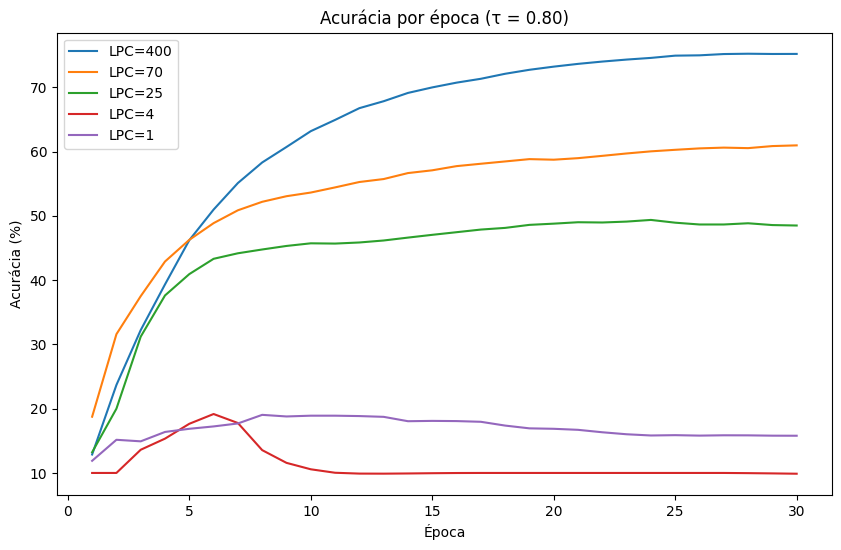

In [39]:
plt.figure(figsize=(10,6))

for lpc in curvas["labels_per_class"].unique():
    subset = curvas[curvas["labels_per_class"] == lpc]
    plt.plot(subset["epoch"], subset["test_acc"], label=f"LPC={lpc}")

plt.title("Acurácia por época (τ = 0.80)")
plt.xlabel("Época")
plt.ylabel("Acurácia (%)")
plt.legend()
plt.grid(False)
plt.show()

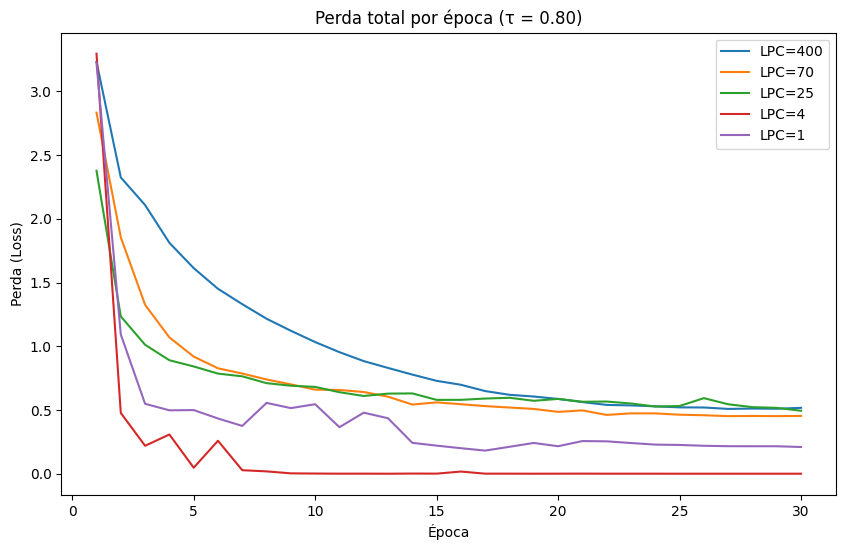

In [36]:
plt.figure(figsize=(10,6))

for lpc in curvas["labels_per_class"].unique():
    subset = curvas[curvas["labels_per_class"] == lpc]
    plt.plot(subset["epoch"], subset["train_loss"], label=f"LPC={lpc}")

plt.title("Perda total por época (τ = 0.80)")
plt.xlabel("Época")
plt.ylabel("Perda (Loss)")
plt.legend()
plt.grid(False)
plt.show()

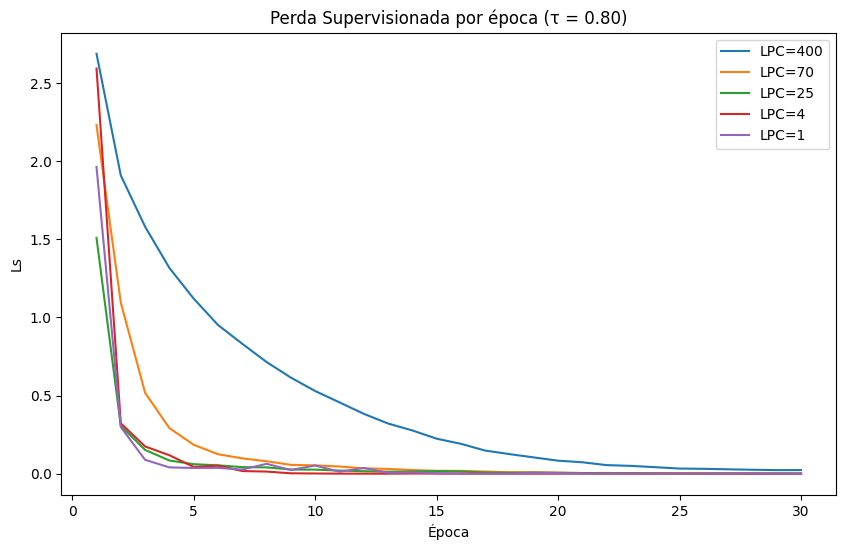

In [38]:
plt.figure(figsize=(10,6))

for lpc in curvas["labels_per_class"].unique():
    subset = curvas[curvas["labels_per_class"] == lpc]
    plt.plot(subset["epoch"], subset["train_Ls"], label=f"LPC={lpc}")

plt.title("Perda Supervisionada por época (τ = 0.80)")
plt.xlabel("Época")
plt.ylabel("Ls")
plt.legend()
plt.grid(False)
plt.show()


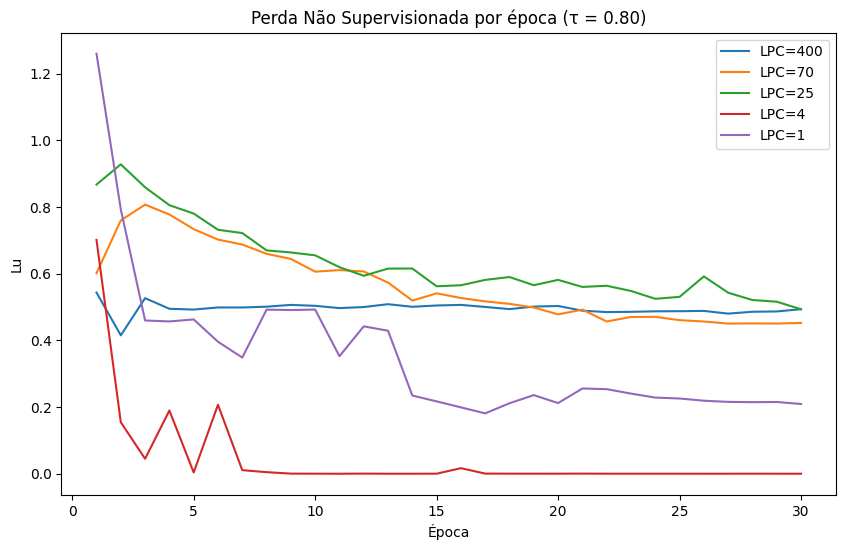

In [40]:
plt.figure(figsize=(10,6))

for lpc in curvas["labels_per_class"].unique():
    subset = curvas[curvas["labels_per_class"] == lpc]
    plt.plot(subset["epoch"], subset["train_Lu"], label=f"LPC={lpc}")

plt.title("Perda Não Supervisionada por época (τ = 0.80)")
plt.xlabel("Época")
plt.ylabel("Lu")
plt.legend()
plt.grid(False)
plt.show()

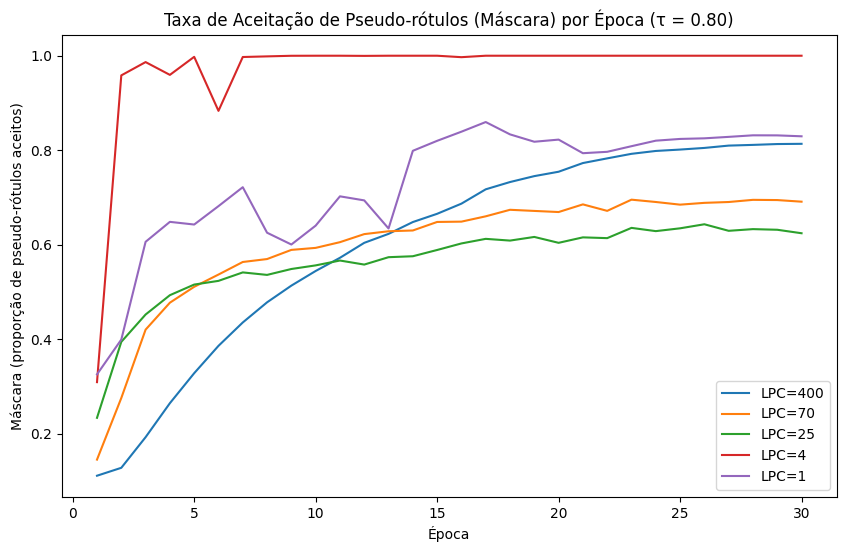

In [41]:
plt.figure(figsize=(10,6))

for lpc in curvas["labels_per_class"].unique():
    subset = curvas[curvas["labels_per_class"] == lpc]
    plt.plot(subset["epoch"], subset["train_mask"], label=f"LPC={lpc}")

plt.title("Taxa de Aceitação de Pseudo-rótulos (Máscara) por Época (τ = 0.80)")
plt.xlabel("Época")
plt.ylabel("Máscara (proporção de pseudo-rótulos aceitos)")
plt.legend()
plt.grid(False)
plt.show()
